# Assignment 8 - Using Deep Features for Image Retrieval

### <span style="color:red">THIS IS HOMEWORK.</span>
### <span style="color:red">Part 2 of 2.</span>
### Due: June 6, 11:59 pm on Canvas.
> **Copyright ©2019 University of Washington**  

> **Emily Fox**, author of the TuriCreate based version of this assignment.  
> **Sewoong Oh**, instructor of CSE/STAT 416 for Spring 2019.       
> **Henry Wong**, revised the 2nd part of this assignment.    
> **Hongjun Wu**, rewrote the prompt of this assignment.    
> **All rights reserved.**

### Clarification
* <span style="color:red">Read & post to this [Assignment 8 Clarifications](https://canvas.uw.edu/courses/1271722/discussion_topics/4846944) if you are not sure of something.</span>

### Purpose
* We will explore the use of deep learning for image retrieval. 
* We will work through the deep learning workflow by finding nearest neighbor of an image. 
 
### Method & Summary
* We will use CIFAR-10 image dataset to create a deep learning model to find nearest neighbor of an image.
* We will use transfer learning and compute using pre-computed deep features.

### Permission
* Permission is hereby granted to students registered for University of Washington CSE/STAT 416.
* For use solely during Spring Quarter 2019 for purposes of the course.  
* No other use, copying, distribution, or modification is permitted without prior written consent. 
* Copyrights for third-party components of this work must be honored.  
* Instructors interested in reusing these course materials should contact the author.

> * If you have any questions or you are unclear what we are refering to in this homework, please do not hesitate to reach out! Post a discussion and we would love to listen to and answer your questions. Hope you enjoy this assignment! 

<img align="center" src="https://i.imgur.com/H01sZ5R.jpg" alt="meme" width="450">

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Load the CIFAR-10 dataset

* We will use a popular benchmark dataset in computer vision called CIFAR-10.  

* (We've reduced the data to just 4 categories = {'cat','bird','automobile','dog'}.)

* Note as always, you are always welcome to use a different directory of data file if you wish, it won't affect our grading.

In [3]:
image_train = pd.read_csv('/data/image_train_data.csv')
image_test = pd.read_csv('/data/image_test_data.csv')

<img align="center" src="https://i.imgur.com/7K5UvGC.jpg" alt="meme" width="200">
* Let's take a look at the DataFrame yet again.

In [4]:
image_train.head()

,id,image,label,deep_features,image_array
0,24,Height: 32 Width: 32,bird,[0.242872 1.09545 0 0.39363 0 0 11.8949 0 0 0 ...,[73 77 58 71 68 50 77 69 44 120 116 83 125 120...
1,33,Height: 32 Width: 32,cat,[0.525088 0 0 0 0 0 9.94829 0 0 0 0 0 1.01264 ...,[7 5 8 7 5 8 5 4 6 7 4 7 11 5 9 11 5 9 17 11 1...
2,36,Height: 32 Width: 32,cat,[0.566016 0 0 0 0 0 9.9972 0 0 0 1.38345 0 0.7...,[169 122 65 131 108 75 193 196 192 218 221 222...
3,70,Height: 32 Width: 32,dog,[1.1298 0 0 0.778194 0 0.758051 9.83053 0 0 0....,[154 179 152 159 183 157 165 189 162 174 199 1...
4,90,Height: 32 Width: 32,bird,[1.71787 0 0 0 0 0 9.33936 0 0 0 0 0 0.412137 ...,[216 195 180 201 178 160 210 184 164 212 188 1...


## Reformat Data & Pre-processing

* Notice how the arrays given in the `deep_features` and `image_array` columns don't have commas? 
    * This is due to how the DataFrame was saved as a `.CSV` file. 
* Thils will make our life difficult later when we are trying to do computations, since the input to our models must be a properly-formatted array. So we will do some preprocessing. 
* We will change the two columns from `str` type to numpy arrays, and also change the `id` column from `str` to `int`. 

In [5]:
def str_to_array(array_str):
    array = eval(array_str.replace(' ', ','))
    return np.array(array)

for dataset in [image_test, image_train]:
    for column in ['deep_features', 'image_array']:
        dataset[column] = dataset[column].apply(str_to_array)
    dataset['id'] = dataset['id'].astype(int)

**Question 2.1:** What is the least common category in the training data? bird

* Hint: `groupby` might help? Just sayin.

In [9]:
# Student writes code here
image_train.groupby('label')['image_array'].count()

label
automobile    509
bird          478
cat           509
dog           509
Name: image_array, dtype: int64

### Explore the images
Here's a function to display the images neatly! This is the exact same code from Part 1 of the assignment.

In [10]:
# image_rows is an SFrame
def get_pixel_data(image_array):
    """
    helper function to get pixel data from the image array
    """
    return np.array(image_array, dtype=np.uint8).reshape((32,32,3))
    
def show_images(image_rows):
    """
    takes rows from the dataframe to display its images and labels
    """
    n = len(image_rows)
    width = 5 # change this to have more images in each row
    fig = plt.figure()
    fig.set_size_inches(width * 2, n / 2 + 1)
    for i in range(n):
        axis = fig.add_subplot(n / width + 1, width, i + 1)
        axis.set_axis_off()
        axis.set_title(image_rows.iloc[i]['label'])
        plt.imshow(get_pixel_data(image_rows.iloc[i]['image_array']))

> #### (Also copied from part 1 for your convenience) 
> #### Okay, we get this piece of code that we just need to run, but how does it work?
* `get_pixel_data`: Takes in an `image_array` and serves as a helper method to reshape it into a np array.
* `show_image`: Well, shows image.
    * `n`: How many images we want python to show.
    * `width`: We set it to `5`, but you can always change it to make a row show more or fewer images.
    * `fig`: a `plt.figure()` object, basically, a figure.
    * Then the for loop pretty much just uses `set_title` to show you a title and uses `plt.imshow()` as well as the `get_pixel_data` helper method to actually render the image (32x32 pixels, each pixel with a different R, G, B value.) 
* Makes more sense? Great.

### Use image retrieval model with deep features to find similar images

* Let's find similar images to this cat picture.

* But first, let's take a look at one cat image.
> An orange and fuzzy cat! Exactly the cat I want to have in the future!

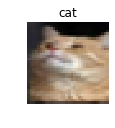

In [11]:
cat = image_train[18:19]
show_images(cat)

### Train a nearest-neighbors model for retrieving images using deep features

* We have provided a custom nearest neighbor class to help with finding similar pictures, the class is based on the [NearestNeighbors](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors) object from sklearn. 
* Take some time to read the documentation of that object and the doc strings of the provided class to get familiar with its use.
* This time, we will just give you the code for this class, but make sure you understand and know how to use it!

In [12]:
from sklearn.neighbors import NearestNeighbors
class nearest_neighbors:
    """
    A custom nearest neighbor model class to make fiting, and querying
    items easier.
    """
    def __init__(self):
        self.model = NearestNeighbors()
        self.data = None
        self.column = None
    def fit(self, X, column):
        """
        fits the knn model
        
        params:
        X: a pandas dataframe of the training data
        column: a string refering to the feature column of the dataframe
        """
        self.data = X
        self.column = column
        self.model.fit(np.stack(X[column].values))
        
    def query(self, y, n=5):
        """
        queries the top n closest neighbors of the given y
        
        params:
        y: a single row of a pandas dataframe
        n: the number of closest results, defaults to 5
        """
        y = np.stack(y[self.column].values)
        query = self.model.kneighbors(y, n_neighbors=n)
        return self.data.iloc[query[1][0]]
    
    def query_distances(self, y, n=5):
        """
        gets the distances to the top n closest results from y
        
        params:
        y: a single row of a pandas dataframe
        n: the number of closest results, defaults to 5
        """
        y = np.stack(y[self.column].values)
        query = self.model.kneighbors(y, n_neighbors=n)
        return query[0]
    

Now, train a nearest neighbor model called `knn_model` on the training data using `deep_features`.

In [13]:
# Student writes code here
knn_model = nearest_neighbors()
knn_model.fit(image_train, 'deep_features')

* We are going to create a simple function to view the nearest neighbors.
    * In order to save the query, run the following line:

In [14]:
cat_neighbors = knn_model.query(cat)

* Let's take a look at cats that are similar to the cat image we picked a while ago.
>* If you happen to have a magic wand with you, you might want to grab it and point it to the laptop screen and say the magic spell 'show me similar cats!!!'
    * Well, don't forget to hit Shift+Enter to activate the magic. Otherwise the magic won't work.

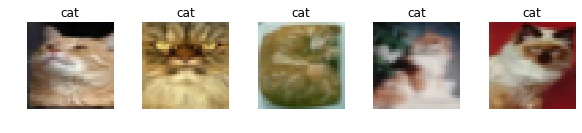

In [15]:
show_images(cat_neighbors)

* Makes sense, right? 
* The nearest neighbor is, well, the orange cat itself. Other nearest neighbors are all cats that has a similar color.

### Finding similar images to a car
* Now, let's find some similar cars.
* Let's pick this red car as an example.

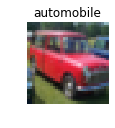

In [16]:
car = image_train[8:9]
show_images(car)

* Now, let's show cars that are similar to this car.

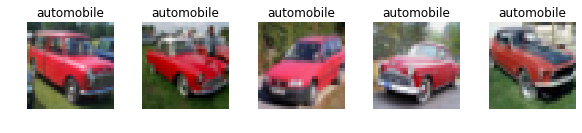

In [17]:
show_images(knn_model.query(car))

* Quite similar, right? All the cars are bright red color with a similar shape to the car we chose.

### Find Similar Gray Cat
* Alright, let's come back to the cats and do another round of demonstration.
* This time, let's pick a gray cat in the training set.

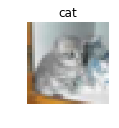

In [16]:
grey_cat = image_train[2:3]
show_images(grey_cat)

* Let's see what are the cats the machine thinks is similar to the cat we chose.

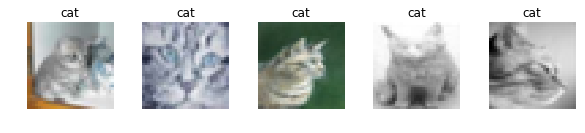

In [22]:
show_images(knn_model.query(grey_cat))

* That's a pretty good demonstration, let's try to train a model on our own.

### Extra Clarification
* Well, last year I found this a bit confusing so I am making it clear here. We will be using this image (`image_test[0:1]`) for the next two questions. We are just using this image - whether it is a dog or a cat doesn't matter. Hope this makes it a bit clearer.

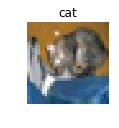

In [23]:
show_images(image_test[0:1])

### Train our own kNN model

***Question 2.2:*** Of the images below, which is the nearest `cat` labeled image in the training data to the the first image in the test data `image_test[0:1]`? 6th

* Hint: For this question, train a NEW `nearest_neighbors` model on only the images labeled `cat` using the `deep_features` in the `training set`.


![cats](https://courses.cs.washington.edu/courses/cse416/18sp/content/cats.png)

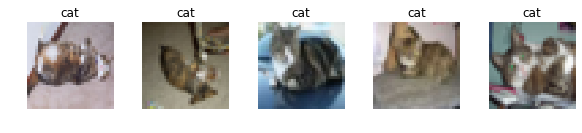

In [19]:
# Student writes code here
new_knn = nearest_neighbors()
new_knn.fit(image_train[image_train['label'] == 'cat'], 'deep_features')
cat_neighbors = new_knn.query(image_test[0:1])
show_images(cat_neighbors)


***Question 2.3:*** Of the images below, which is the nearest `dog` labeled image in the training data to the the first `image` in the test data `image_test[0:1]`? 4th 

For this question, train a new `nearest_neighbors` model on only the images labeled `dog` using the `deep_features` in the `training set`.

![cats](https://courses.cs.washington.edu/courses/cse416/18sp/content/dogs.png)

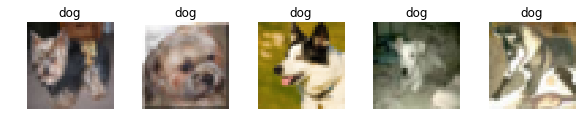

In [21]:
# Student writes code here
dog_knn = nearest_neighbors()
dog_knn.fit(image_train[image_train['label'] == 'dog'], 'deep_features')
dogs = dog_knn.query(image_test[0:1])
show_images(dogs)


***Question 2.4:*** For the first image in the test data, in what range is the `mean` distance between this image and its 5 nearest neighbors that were labeled ‘cat’ in the training data? b

a) 33 - 35  
b) 35 - 37  
c) 37 - 39  
d) 39 - 41  
e) Above 41

In [23]:
# Student writes code here
new_knn.query_distances(image_test[0:1], n=5).mean()

36.15572932231885

***Question 2.5:*** For the first image in the test data, in what range is the mean distance between this image and its 5 nearest neighbors that were labeled ‘dog’ in the training data? c

a) 33 - 35  
b) 35 - 37  
c) 37 - 39  
d) 39 - 41  
e) Above 41

In [24]:
# Student writes code here
dog_knn.query_distances(image_test[0:1], n=5).mean()

37.77071193352956

***Question 2.6:*** On average, is the first image in the test data closer to its 5 nearest neighbors in the ‘cat’ data or in the ‘dog’ data? cat

a) cat  
b) dog  

### Other Stuff
##### Course Evaluation
* At the time of writing this assignment, the `Course Evaluation` isn't out yet, but I imagine they will be out soon. **Please please please please** fill them out, regardless of your opinion on your TA or our instructor. It helps us because we can get feedback on how we did and improve in the future, and it also helps the department so we can make this course even better going forward.


###### Bob Bandes Award
* Also, if you really like one of the TAs in this course because you think he or she did an awesome job, please consider nominate he/she for the [Bob Bandes Award](https://www.cs.washington.edu/students/ta/bandes). This means a lot for us as a CSE TA!

<img align="center" src="https://i.imgur.com/CFchJ0M.jpg" alt="meme" width="150">    




### Conclusion
* Hey! You just reached the end of this assignment, well, the end of CSE416 assignment in general as well! Congratulations!
* It's not much, but we hope you can get an idea of what Deep Learning is and what it can do. It's just not enough time for us to squeeze in a lot of deep learning into the very tight ten week schedule, but if you are interested, please learn more after you completed this course.
* We know we are not perfect, so thanks sooooo much for going along with us together. Really appreciate it!
* Best wishes to your future, and good luck on the exam!